In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
import sys
import matplotlib.colors as colors
import os
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats

In [2]:
n_clusters=1000
f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [3]:
f = h5py.File('../data/Foraging_N2/phspace_K_10_m_7.h5','r')
traj_matrix = ma.masked_invalid(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
traj_matrix[traj_matrix==0]=ma.masked
f.close()

In [5]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'])
f.close()

eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

In [6]:
kmeans_labels = labels_tree[0,:]
print(np.unique(kmeans_labels))
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

[0. 1.]


In [7]:
cluster_traj_w = cluster_traj.reshape((12,33600))

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [16]:
frameRate=16.
dt=1/frameRate
len_w = 33600
wsize = int(5*60*frameRate)
n_worms=12
pir_per_min_w = []
for kw in range(n_worms):
    wavg_ctraj = ma.masked_invalid(moving_average(cluster_traj_w[kw],int(delay)))
    wavg_ctraj[cluster_traj_w[kw].mask] = ma.masked
    mask = wavg_ctraj<.5
    segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
    tcenters = np.arange(0,len(wavg_ctraj)-int(wsize/2),int(wsize/2)) 
    pir_per_min = np.array([np.logical_and(segments[:,0]>t0,segments[:,0]<t0+wsize).sum()/wsize*frameRate*60 for t0 in tcenters])
    pir_per_min_w.append(pir_per_min)
    print(kw)

0
1
2
3
4
5
6
7
8
9
10
11


In [12]:
sims_w = []
f = h5py.File('../data/symbol_seq_sims/symbol_sequence_simulations.h5','r')
for worm in np.arange(n_worms):
    sims = np.array(f['{}/sims'.format(worm)],dtype=int)
    sims_w.append(sims)
print(np.array(f['MetaData/delay'])[0])
f.close()

12.0


In [13]:
wsize_sim = int(5*60*frameRate/delay)
pir_per_min_sim_ci_w = []
pir_per_min_sim_w = []

for kw in range(n_worms):
    pir_per_min_sim = []
    for ks in range(1000):
        sim = sims_w[kw][ks]
        label_sim = ma.array(kmeans_labels[sim])
        mask = label_sim==0
        segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
        tcenters_sim = np.arange(0,len(label_sim)-int(wsize_sim/2),int(wsize_sim/2))
        pir_per_min = np.array([np.logical_and(segments[:,0]>t0,segments[:,0]<t0+wsize_sim).sum()/wsize*frameRate*60 for t0 in tcenters_sim])
        pir_per_min_sim.append(pir_per_min)
    mean = np.vstack(pir_per_min_sim).mean(axis=0)
    cil = np.percentile(np.vstack(pir_per_min_sim),2.5,axis=0)
    ciu = np.percentile(np.vstack(pir_per_min_sim),97.5,axis=0)
    pir_per_min_sim_ci_w.append(np.vstack([mean,cil,ciu]).T)
    pir_per_min_sim_w.append(pir_per_min_sim)

    print(kw)

0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
[pir_per_min_w[kw].mean() for kw in range(n_worms)]

[5.323076923076924,
 2.907692307692308,
 3.507692307692307,
 2.7230769230769236,
 2.8769230769230774,
 3.5230769230769234,
 2.523076923076923,
 2.1846153846153844,
 3.5384615384615383,
 2.6307692307692303,
 2.8615384615384616,
 1.5846153846153845]

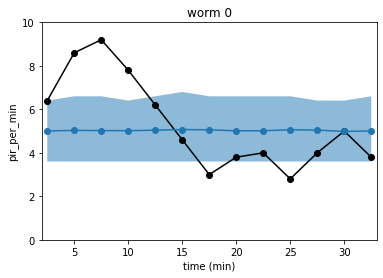

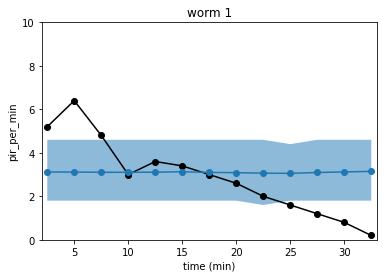

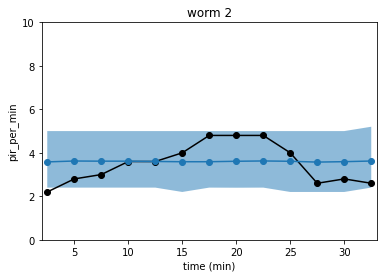

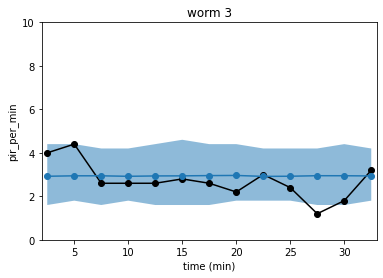

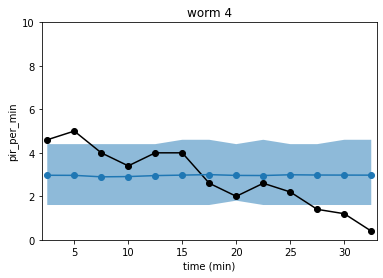

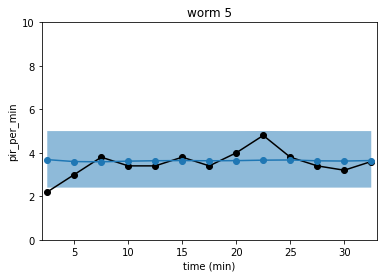

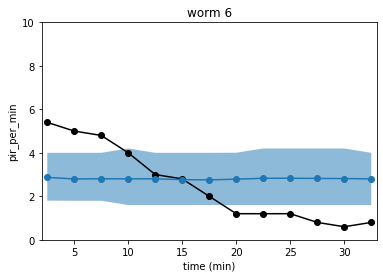

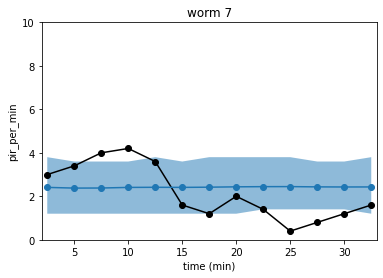

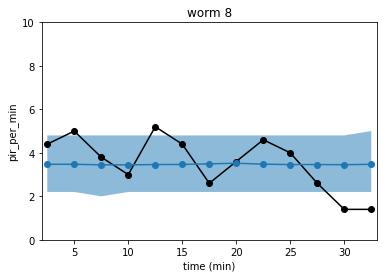

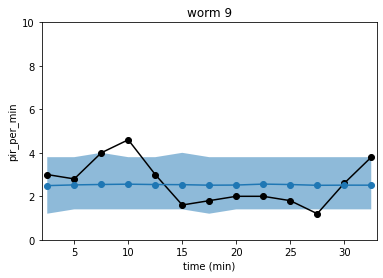

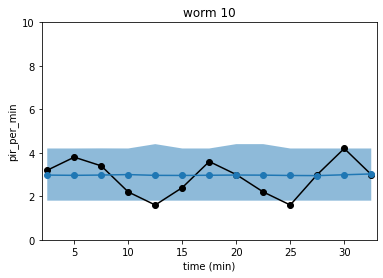

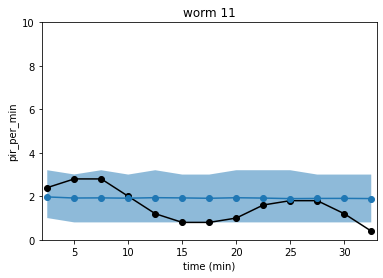

In [17]:
for kw in range(n_worms):
    plt.title('worm {}'.format(kw))
    plt.plot((tcenters+wsize/2)*dt/60,pir_per_min_w[kw],c='k',marker='o')
    plt.plot((tcenters_sim+wsize_sim/2)*delay*dt/60,pir_per_min_sim_ci_w[kw][:,0],marker='o')
    plt.fill_between((tcenters_sim+wsize_sim/2)*delay*dt/60,pir_per_min_sim_ci_w[kw][:,1],pir_per_min_sim_ci_w[kw][:,2],alpha=.5)
    plt.xlim(2,33)
    plt.ylabel('pir_per_min')
    plt.xlabel('time (min)')
    plt.ylim(0,10)
#     plt.savefig('pir_per_min_w_{}.pdf'.format(kw))
    plt.show()

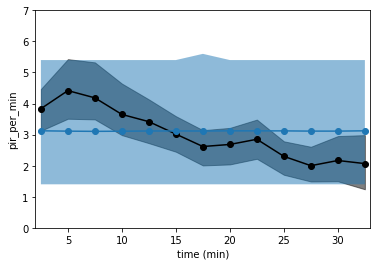

In [18]:
mean,cil,ciu = stats.bootstrap(pir_per_min_w,n_times=100)
plt.plot((tcenters+wsize/2)*dt/60,mean,c='k',marker='o')
plt.fill_between((tcenters+wsize/2)*dt/60,cil,ciu,alpha=.5,color='k')

mean = np.concatenate(np.array(pir_per_min_sim_w),axis=0).mean(axis=0)
cil = np.percentile(np.concatenate(np.array(pir_per_min_sim_w),axis=0),2.5,axis=0)
ciu = np.percentile(np.concatenate(np.array(pir_per_min_sim_w),axis=0),97.5,axis=0)
# mean,cil,ciu = stats.bootstrap(np.concatenate(np.array(pir_per_min_sim_w),axis=0),n_times=10)
plt.plot((tcenters_sim+wsize_sim/2)*delay*dt/60,mean,marker='o')
plt.fill_between((tcenters_sim+wsize_sim/2)*delay*dt/60,cil,ciu,alpha=.5)
plt.xlim(2,33)
plt.ylabel('pir_per_min')
plt.xlabel('time (min)')
plt.ylim(0,7)
# plt.savefig('pir_per_min_avg.pdf')
plt.show()